# Import Library

In [246]:
import warnings
warnings.filterwarnings("ignore")

import math
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from xgboost import XGBClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import SVR, LinearSVC, NuSVC, LinearSVR, NuSVR
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, NearestCentroid, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier, \
     AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegressionCV, RidgeClassifier, ARDRegression, BayesianRidge, \
     ElasticNetCV, Lars, LarsCV, Lasso, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC, OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, \
     PassiveAggressiveRegressor, PoissonRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, TheilSenRegressor, TweedieRegressor

# Load Data

In [247]:
data = pd.read_csv("../cirrhosis.csv").drop(columns=['ID', 'N_Days'])
data = data[data['Stage'].notna()]
data.sample(5)

,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
123,C,D-penicillamine,19318,M,N,Y,N,N,0.6,251.0,3.90,25.0,681.0,57.35,107.0,182.0,10.8,4.0
100,C,Placebo,16418,F,N,N,N,N,0.9,400.0,3.60,31.0,1689.0,164.30,166.0,327.0,10.4,3.0
34,D,Placebo,17758,F,N,N,N,N,1.2,314.0,3.20,201.0,12258.8,72.24,151.0,431.0,10.6,3.0
211,C,Placebo,17263,F,N,N,N,N,1.2,232.0,3.98,11.0,1074.0,100.75,99.0,223.0,9.9,3.0
11,D,Placebo,21600,F,N,N,Y,N,3.6,236.0,3.52,94.0,591.0,82.15,95.0,71.0,13.6,4.0


# Inital Analysis

In [216]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 417
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Status         412 non-null    object 
 1   Drug           312 non-null    object 
 2   Age            412 non-null    int64  
 3   Sex            412 non-null    object 
 4   Ascites        312 non-null    object 
 5   Hepatomegaly   312 non-null    object 
 6   Spiders        312 non-null    object 
 7   Edema          412 non-null    object 
 8   Bilirubin      412 non-null    float64
 9   Cholesterol    284 non-null    float64
 10  Albumin        412 non-null    float64
 11  Copper         310 non-null    float64
 12  Alk_Phos       312 non-null    float64
 13  SGOT           312 non-null    float64
 14  Tryglicerides  282 non-null    float64
 15  Platelets      401 non-null    float64
 16  Prothrombin    410 non-null    float64
 17  Stage          412 non-null    float64
dtypes: float64

In [217]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,412.0,18498.286408,3823.705746,9598.00,15609.2500,18628.00,21200.5000,28650.00
Bilirubin,412.0,3.227670,4.429421,0.30,0.8000,1.40,3.4000,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.0000,1775.00
Albumin,412.0,3.500073,0.423948,1.96,3.2475,3.53,3.7825,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.0000,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.0000,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.9000,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.0000,598.00
Platelets,401.0,256.102244,95.750598,62.00,189.0000,249.00,318.0000,563.00
Prothrombin,410.0,10.733415,1.026557,9.00,10.0000,10.60,11.1000,18.00


### Get Numerical and Categorical Columns

In [248]:
numerical_column = [column for column in data.columns if data[column].dtype != 'object']
print(numerical_column)
categorical_column = [column for column in data.columns if data[column].dtype == 'object']
print(categorical_column)

['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


### Cleaning nan Value 

In [249]:
def set_numerical_nan(data, numerical_column):
    data[numerical_column] = data[numerical_column].fillna(data[numerical_column].mean())
    return data
data = set_numerical_nan(data, numerical_column)

In [250]:
def set_categorical_nan(data, categorical_column):
    imp = SimpleImputer(strategy="most_frequent")
    data[categorical_column] = imp.fit_transform(data[categorical_column])
    return data
data = set_categorical_nan(data, categorical_column)

### Change the unit of Age from days to years

In [251]:
data["Age"] = (data["Age"].values/365).round()

# Data Exploration

### Distribution value for numerical columns

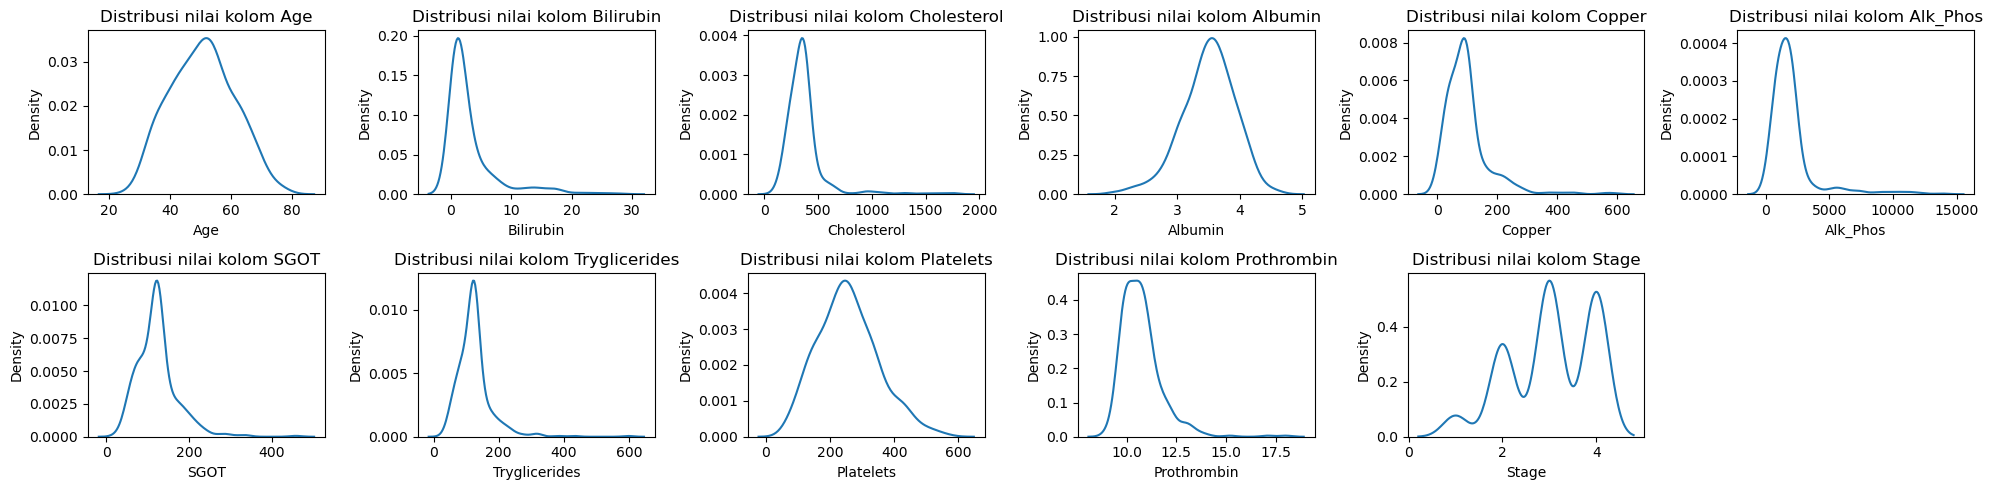

In [12]:
num_rows = 2
num_cols = math.ceil(len(numerical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data, x=column, ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Distribution value for numerical columns based on Gender

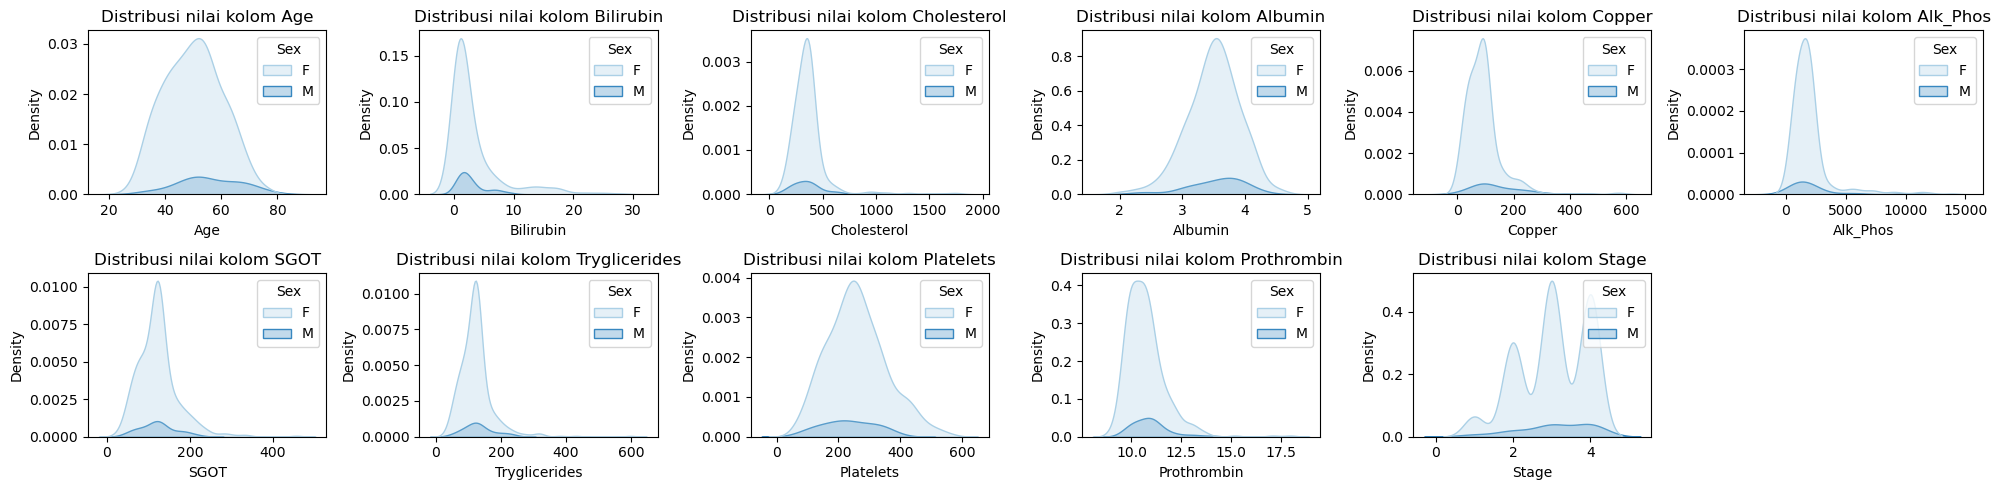

In [13]:
num_rows = 2
num_cols = math.ceil(len(numerical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data, x=column, hue="Sex", fill=True, alpha=.3, palette="Blues", ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Count of each value for categorical columns

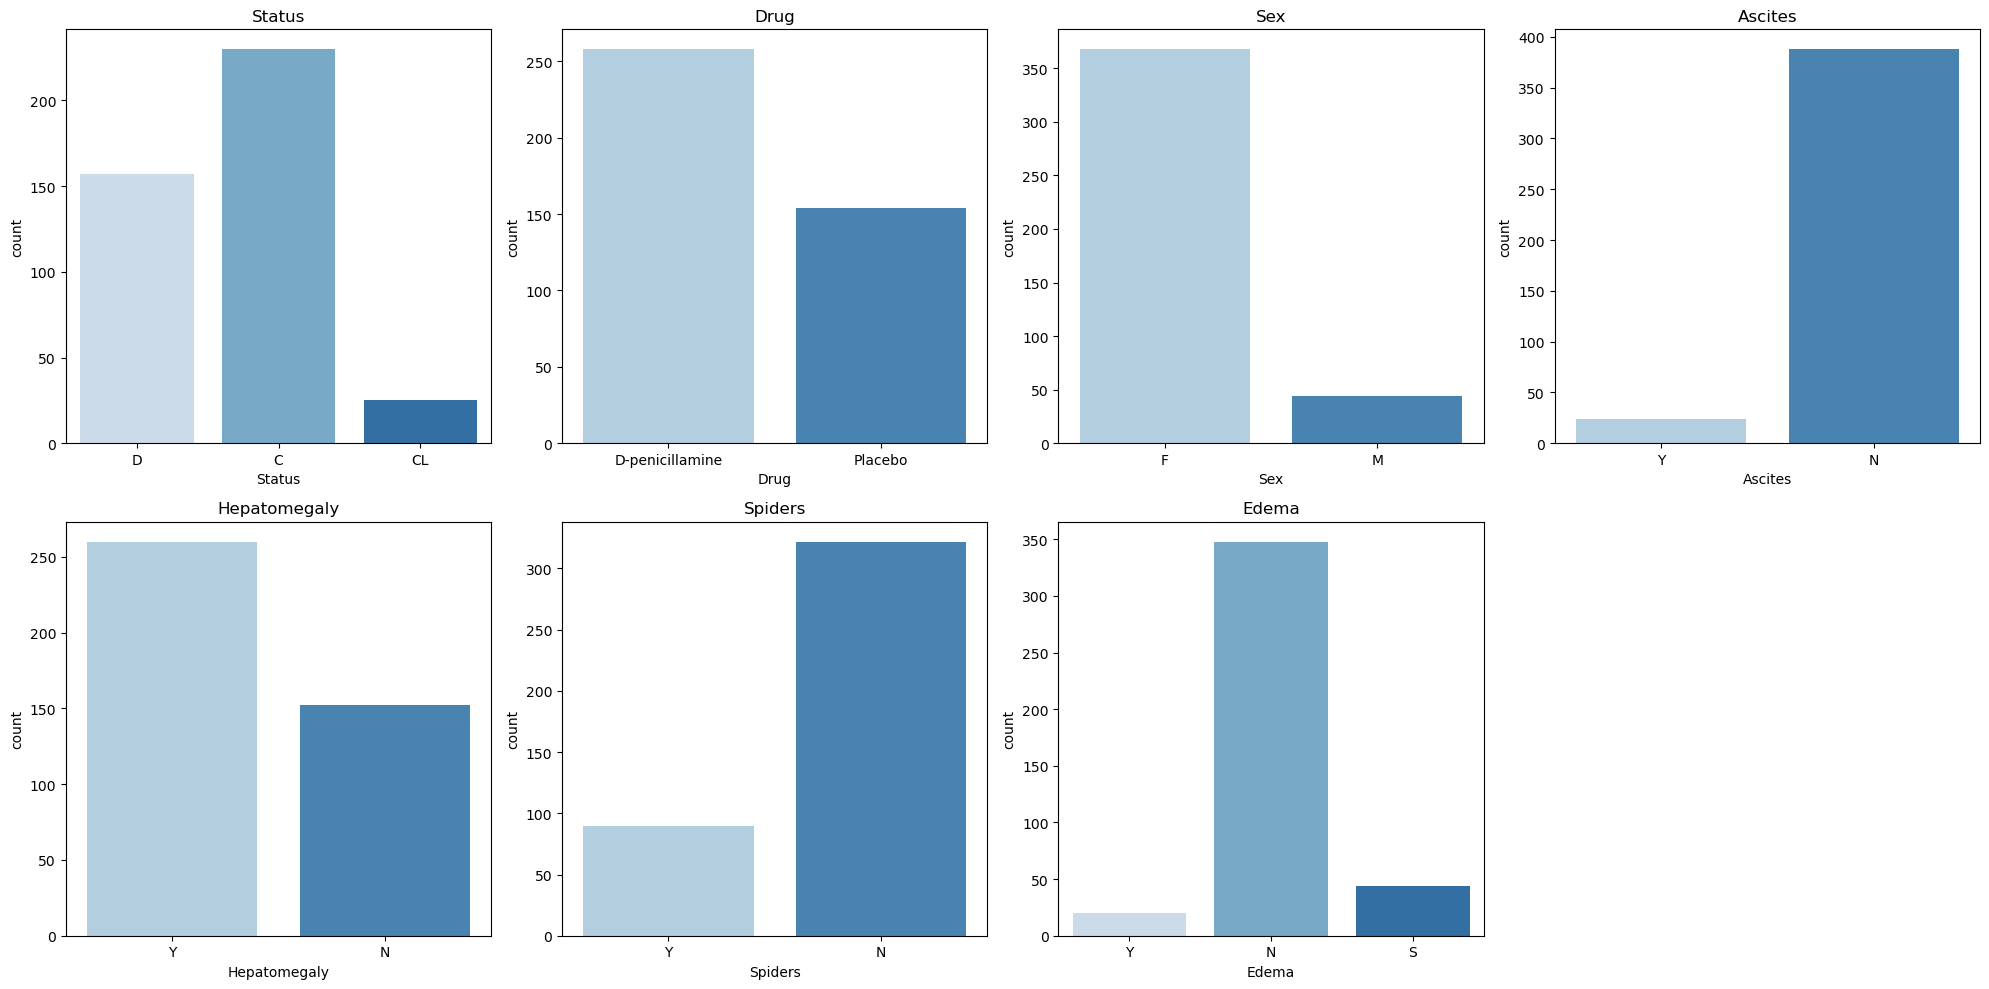

In [258]:
num_rows = 2
num_cols = math.ceil(len(categorical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(categorical_column):
    row = i // num_cols
    col = i % num_cols
    sns.countplot(x=data[column], ax=axes[row, col], palette="Blues").set_title(column)
    
    
for i in range(len(categorical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### The range of values in the numerical column

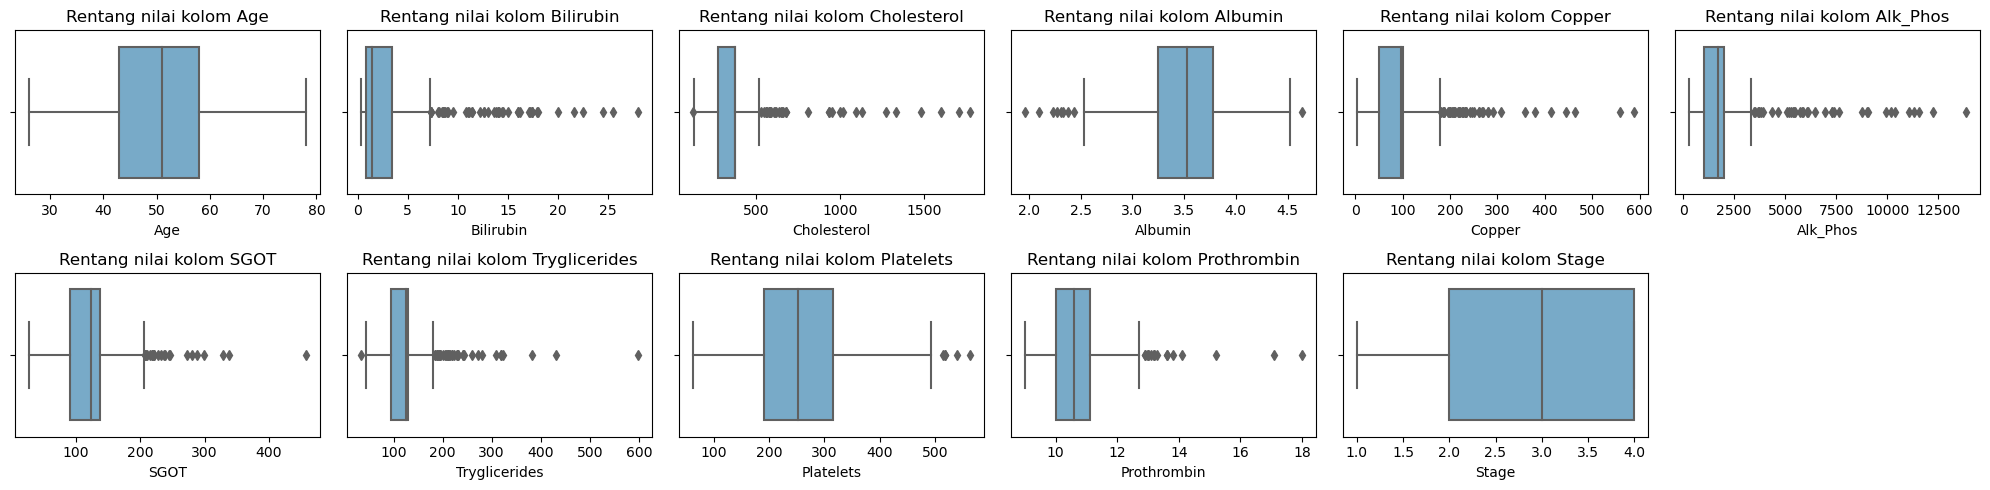

In [252]:
num_rows = 2
num_cols = math.ceil(len(numerical_column) / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Blues").set_title("Rentang nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Remove Outlier from the data

In [258]:
Q1   = data.quantile(0.25)
Q3   = data.quantile(0.75)
IQR  = Q3-Q1
data = data[~((data<(Q1-1.5*IQR))|(data>(Q3+1.5*IQR))).any(axis=1)].dropna()
data.shape

(191, 18)

# Data correlation between columns

<Axes: >

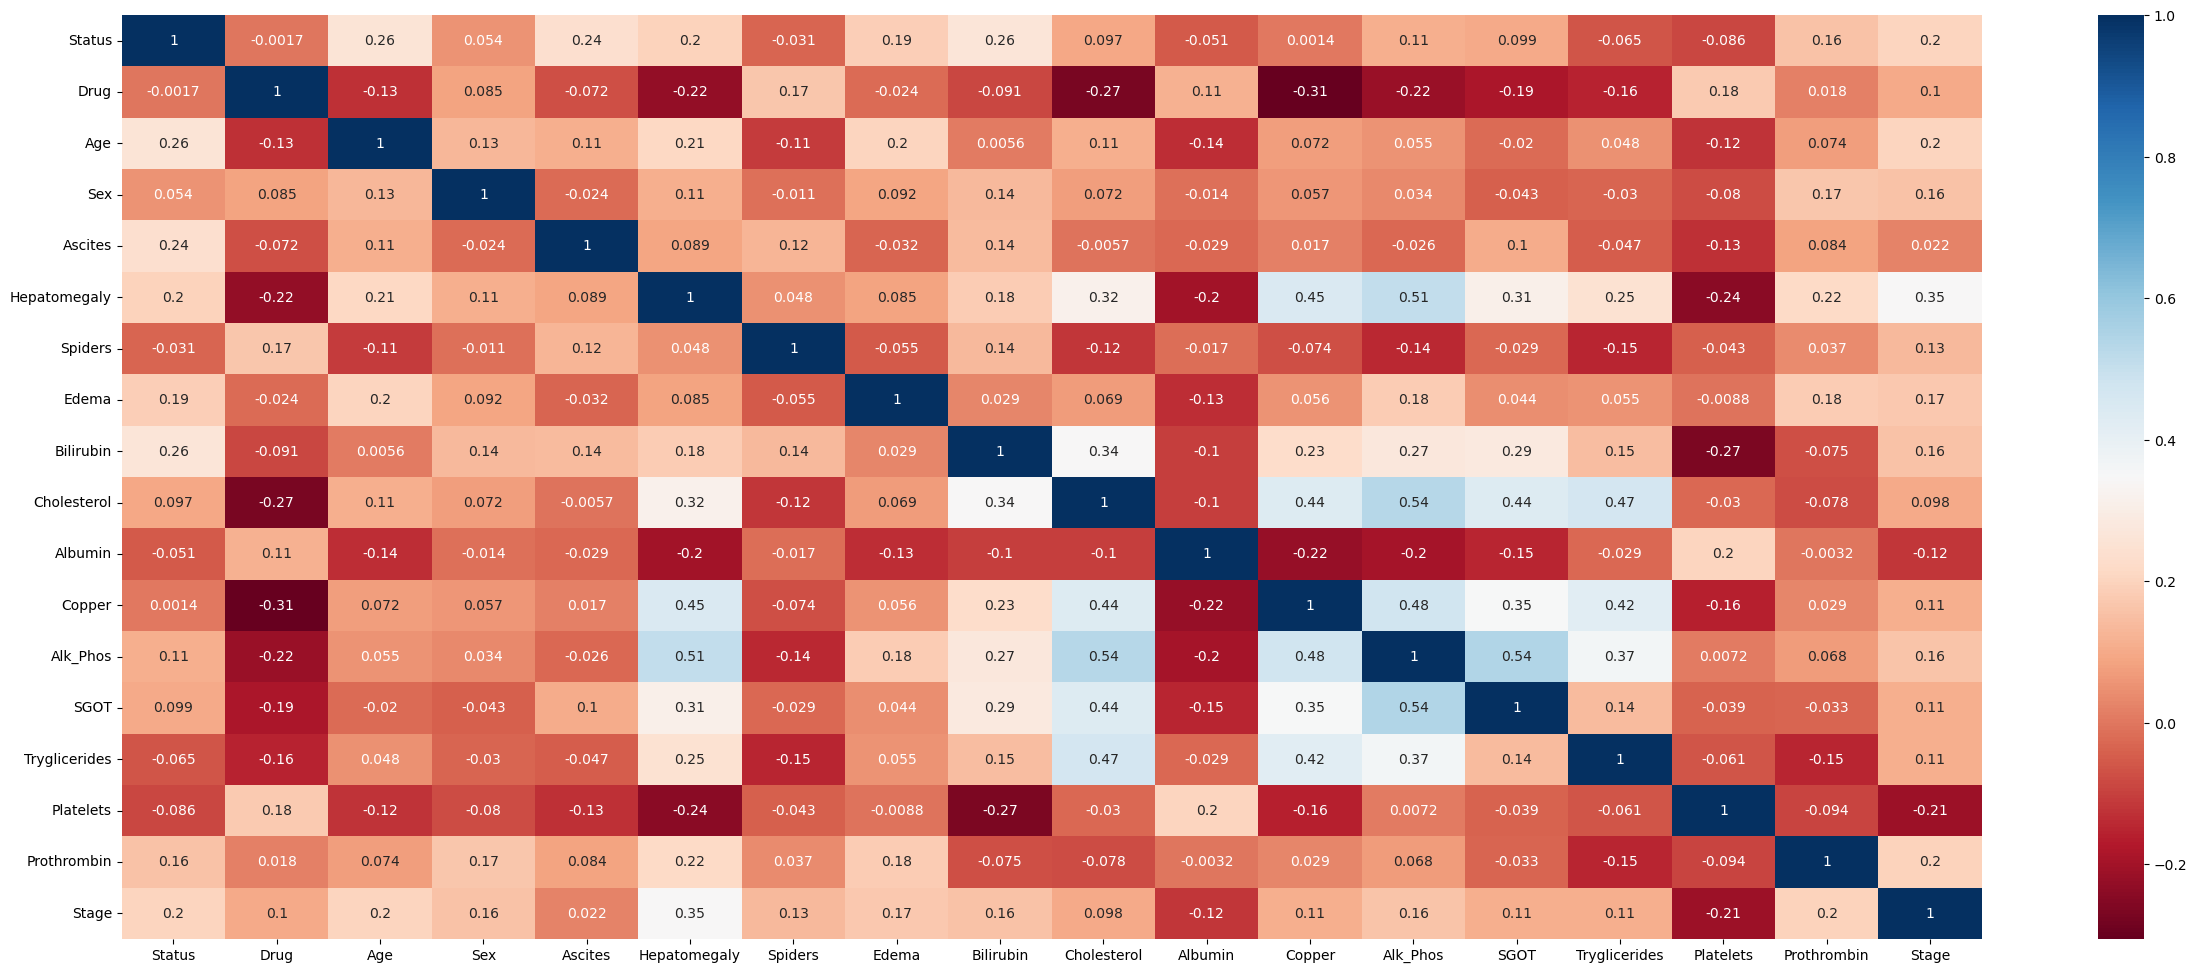

In [259]:
datacorr = data.copy()

encoder = LabelEncoder()
for column in categorical_column:
    datacorr[column] = encoder.fit_transform(datacorr[column])

plt.figure(figsize=(30,12))
corr = datacorr.corr()
sns.heatmap(corr, annot=True, cmap="RdBu")

# Data Preprocessing

In [260]:
data = pd.get_dummies(data, columns = categorical_column)

X = data.drop(columns=['Stage'])
Y = data['Stage'].astype('int8')

print(Counter(Y))

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
print(Counter(Y))

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Counter({3: 77, 2: 53, 4: 46, 1: 15})
Counter({3: 77, 4: 77, 2: 77, 1: 77})


### Split data to Train and Test data

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {(X_train.shape)}')
print(f'Total # of sample in test dataset: {(X_test.shape)}')

Total # of sample in whole dataset: 308
Total # of sample in train dataset: (246, 25)
Total # of sample in test dataset: (62, 25)


# Model Prediction

### Prepare Model

In [262]:
def algorithms():
    algorithms = [
                    ### Classification ###
                  ('AdaBoost', AdaBoostClassifier(n_estimators=51, learning_rate=0.1, random_state=42)),
                  ('Bernoulli NB', BernoulliNB()),
                  ('Gradient Boost', GradientBoostingClassifier(n_estimators=46, learning_rate=0.1, max_depth=50, random_state=42)),
                  ('KNN', KNeighborsClassifier(n_neighbors=4)),
                  ('Linear SVC',LinearSVC(random_state=42, tol=1e-1)),
                  ('Multinomial NB', MultinomialNB()),
                  ('Nu SVC', NuSVC()),
                  ('Random Forest',RandomForestClassifier(max_depth=7, random_state=42)),
                  ('Ridge',RidgeClassifier()),
                  ('SGD', SGDClassifier(max_iter=63,loss='hinge', penalty='l2', alpha=1e-3, random_state=42, tol=None)),
        
                    ### Regression ###
                  ('ARD',ARDRegression()),
                  ('AdaBoost',AdaBoostRegressor(n_estimators=27, random_state=42)),
                  ('Bayesian Ridge',BayesianRidge()),
                  ('Decision Tree', DecisionTreeRegressor(max_depth=4)),
                  ('Elastic Net CV', ElasticNetCV(random_state=42)),
                  ('Gradient Boost', GradientBoostingRegressor(n_estimators=5, learning_rate=0.1, max_depth=50, random_state=42)),
                  ('Hist Gradient B',HistGradientBoostingRegressor()),
                  ('Kernel Ridge',KernelRidge(alpha=.1)),
                  ('KNN', KNeighborsRegressor(n_neighbors=4)), 
                  ('Lars',Lars(n_nonzero_coefs=26)),
                  ('Lars CV',LarsCV(cv=6)),
                  ('Lasso',Lasso(alpha=1e-4)),
                  ('Lasso CV', LassoCV(cv=6, random_state=42)),
                  ('Lasso Lars', LassoLars(alpha=1e-5)),
                  ('Lasso Lars CV', LassoLarsCV(cv=6)),
                  ('Lasso Lars IC', LassoLarsIC(criterion='aic')),
                  ('Linear Regression', LinearRegression()), 
                  ('Linear Regression CV', LogisticRegressionCV(cv=2, random_state=42)),
                  ('Linear SVR', LinearSVR(random_state=42, tol=1e-5)),
                  ('MLP', MLPRegressor(hidden_layer_sizes=(10000,), max_iter=100, random_state=42)),
                  ('Nu SVR',NuSVR(C=1, nu=0.6)),
                  ('Orthogonal MP', OrthogonalMatchingPursuit()),
                  ('Orthogonal MP CV', OrthogonalMatchingPursuitCV(cv=3)),
                  ('Passive Aggressive',PassiveAggressiveRegressor(max_iter=4, random_state=42, tol=1e-1)),
                  ('Poisson', PoissonRegressor()),
                  ('Random Forrest', RandomForestRegressor(n_estimators=14, max_depth=50, random_state=42)),
                  ('RANSAC', RANSACRegressor(random_state=42)),
                  ('Ridge', Ridge(alpha=.1)),
                  ('RidgeCV', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
                  ('SGD', SGDRegressor(max_iter=116, tol=1e-4, random_state=42)),
                  ('SVR', SVR(kernel='rbf')), 
                  ('TheilSen',TheilSenRegressor(random_state=42)),
                  ('Tweedie', TweedieRegressor(power = 1)),
                  ]
    return algorithms

def prepare_model(algorithm):
    model = algorithm
    model.fit(X_train, y_train)
    return model

def calculate_regression_performance(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = round(model.score(X_train,y_train), 4)*100
    mse = round(mean_squared_error(y_test, y_pred), 2)
    r2  = round(r2_score(y_test, y_pred), 2)
    return acc, mse, r2

def regression_result(result, name, acc, mse, r2):
    result.append((name, acc, mse, r2))
    return result

### Training and Evaluate the model

In [263]:
%%time
result = []
trained_models = []

algorithms = algorithms()

for index, tup in enumerate(algorithms):
    model = prepare_model(tup[1])
    trained_models.append((tup[0],model))

    # Calculate the Accuracy, Mean Squared Error (MSE), and R-squared score
    acc, mse, r2= calculate_regression_performance(model,X_train, y_train, X_test, y_test)
    result = regression_result(result, tup[0], acc, r2, mse)

regression_results_df = pd.DataFrame(result, columns=('Model Name', 'Accuracy', 'R-Square', 'MSE'))
regression_results_df.sort_values(by=['R-Square', 'Accuracy'], ascending=False)

CPU times: total: 25.8 s
Wall time: 6.25 s


,Model Name,Accuracy,R-Square,MSE
16,Hist Gradient B,93.51,0.61,0.47
35,Random Forrest,91.74,0.60,0.48
11,AdaBoost,62.77,0.52,0.58
30,Nu SVR,63.41,0.50,0.60
40,SVR,64.24,0.49,0.63
19,Lars,53.06,0.48,0.64
21,Lasso,53.06,0.48,0.64
23,Lasso Lars,53.06,0.48,0.64
26,Linear Regression,53.06,0.48,0.64
17,Kernel Ridge,51.77,0.48,0.64


### Find optimal hyperparameter for some models

In [213]:
%%time
max_value = 0
num_value = 0
n_number = 100

for i in tqdm(range(n_number)):
    
    ### Classification ###
    model = AdaBoostClassifier(n_estimators=i+1, learning_rate=0.1, random_state=42)
    # model = GradientBoostingClassifier(n_estimators=i+1, learning_rate=0.1, max_depth=50, random_state=42)
    # model = KNeighborsClassifier(n_neighbors=i+1)
    # model =  LinearSVC(random_state=42, tol=(i+1)/100)
    # model = RandomForestClassifier(max_depth=i+1, random_state=42)
    # model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=i+1, tol=None)
    
    ### Regression ###
    # model = AdaBoostRegressor( n_estimators=i+1, random_state=42)
    # model = DecisionTreeRegressor(max_depth=i+1)
    # model = GradientBoostingRegressor(n_estimators=i+1, learning_rate=0.1, max_depth=50, random_state=42)
    # model = KernelRidge(alpha=(i+1)/100)
    # model = KNeighborsRegressor(n_neighbors=i+1)
    # model = Lars(n_nonzero_coefs=i+1)
    # model = LarsCV(cv=i+2)
    # model = Lasso(alpha=(i+1)/100)
    # model = LassoCV(cv=i+2, random_state=42)
    # model = LassoLars(alpha=(i+1)/100)
    # model = LassoLarsCV(cv=i+2)
    # model = LogisticRegressionCV(cv=i+2, random_state=42)
    # model = LinearSVR(random_state=42, tol=(i+1)/100)
    # model = NuSVR(C=i+1, nu=1)
    # model = OrthogonalMatchingPursuitCV(cv=i+2)
    # model = PassiveAggressiveRegressor(max_iter=i+1, random_state=42, tol=1e-3)
    # model = RandomForestRegressor(n_estimators=i+1, max_depth=100, random_state=42)
    # model = Ridge(alpha=(i+1)/100)
    # model = SGDRegressor(max_iter=i+1, tol=1e-4, random_state=42)
    # model = TweedieRegressor(power = i)
    
    model.fit(X_train, y_train)
    # Calculate the R-squared score
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    if (r2> max_value):
        max_value = r2
        num_value = i+1
    
print(max_value)
print(num_value)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.70it/s]

0.3371819542441735
20
CPU times: total: 4.92 s
Wall time: 5.35 s


In [388]:
from sklearn.base import RegressorMixin
from sklearn.utils import all_estimators
classifiers=[est for est in all_estimators() if issubclass(est[1], RegressorMixin)]
for i, model in enumerate (classifiers) :
    print(model)

('ARDRegression', <class 'sklearn.linear_model._bayes.ARDRegression'>)
('AdaBoostRegressor', <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>)
('BaggingRegressor', <class 'sklearn.ensemble._bagging.BaggingRegressor'>)
('BayesianRidge', <class 'sklearn.linear_model._bayes.BayesianRidge'>)
('CCA', <class 'sklearn.cross_decomposition._pls.CCA'>)
('DecisionTreeRegressor', <class 'sklearn.tree._classes.DecisionTreeRegressor'>)
('DummyRegressor', <class 'sklearn.dummy.DummyRegressor'>)
('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
('ElasticNetCV', <class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>)
('ExtraTreeRegressor', <class 'sklearn.tree._classes.ExtraTreeRegressor'>)
('ExtraTreesRegressor', <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>)
('GammaRegressor', <class 'sklearn.linear_model._glm.glm.GammaRegressor'>)
('GaussianProcessRegressor', <class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'>)
('GradientBoostin

In [303]:
from sklearn.base import ClassifierMixin
from sklearn.utils import all_estimators
classifiers=[est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]
for i, model in enumerate (classifiers) :
    print(model)

('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>)
('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>)
('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>)
('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>)
('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>)
('ClassifierChain', <class 'sklearn.multioutput.ClassifierChain'>)
('ComplementNB', <class 'sklearn.naive_bayes.ComplementNB'>)
('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>)
('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>)
('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>)
('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>)
('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>)
('GaussianProcessClassifier', <class 'sklearn.gaussian_process._gpc.GaussianProcessClassifier'>)
('GradientBoostingClassifier', <class 'sklearn.e

In [691]:
def regression_algorithms():
    algorithms = [
                    ### Classification ###
                  ('AdaBoost', AdaBoostClassifier(n_estimators=51, learning_rate=0.1, random_state=42)),
                  ('Bernoulli NB', BernoulliNB()),
                  ('Gradient Boost', GradientBoostingClassifier(n_estimators=46, learning_rate=0.1, max_depth=50, random_state=42)),
                  ('KNN', KNeighborsClassifier(n_neighbors=6)),
                  ('Linear SVC',LinearSVC(random_state=42, tol=1e-1)),
                  ('Linear Regression CV', LogisticRegressionCV(cv=2, random_state=42)),
                  ('Multinomial NB', MultinomialNB()),
                  ('Nu SVC', NuSVC()),
                  ('Random Forest',RandomForestClassifier(max_depth=7, random_state=42)),
                  ('Ridge',RidgeClassifier()),
                  ('SGD', SGDClassifier(max_iter=63,loss='hinge', penalty='l2', alpha=1e-3, random_state=42, tol=None)),
        
                    ### Regression ###
                  ('ARD',ARDRegression()),
                  ('AdaBoost',AdaBoostRegressor(n_estimators=27, random_state=42)),
                  ('Bayesian Ridge',BayesianRidge()),
                  ('Decision Tree', DecisionTreeRegressor(max_depth=4)),
                  ('Elastic Net CV', ElasticNetCV(random_state=42)),
                  ('Gradient Boost', GradientBoostingRegressor(n_estimators=12, learning_rate=0.1, max_depth=50, random_state=42)),
                  ('Hist Gradient B',HistGradientBoostingRegressor()),
                  ('Kernel Ridge',KernelRidge(alpha=.1)),
                  ('KNN', KNeighborsRegressor(n_neighbors=4)), 
                  ('Lars',Lars(n_nonzero_coefs=26)),
                  ('Lars CV',LarsCV(cv=6)),
                  ('Lasso',Lasso(alpha=1e-4)),
                  ('Lasso CV', LassoCV(cv=6, random_state=42)),
                  ('Lasso Lars', LassoLars(alpha=1e-5)),
                  ('Lasso Lars CV', LassoLarsCV(cv=6)),
                  ('Lasso Lars IC', LassoLarsIC(criterion='aic')),
                  ('Linear Regression', LinearRegression()), 
                  ('Linear SVR', LinearSVR(random_state=42, tol=1e-5)),
                  ('MLP', MLPRegressor(hidden_layer_sizes=(10000,), max_iter=100, random_state=42)),
                  ('Nu SVR',NuSVR(C=1, nu=0.6)),
                  ('OrthogonalMatchingPursuit', OrthogonalMatchingPursuit()),
                  ('OrthogonalMatchingPursuitCV', OrthogonalMatchingPursuitCV(cv=3)),
                  ('Passive Aggressive',PassiveAggressiveRegressor(max_iter=4, random_state=42, tol=1e-1)),
                  ('Poisson', PoissonRegressor()),
                  ('Random Forrest', RandomForestRegressor(n_estimators=14, max_depth=50, random_state=42)),
                  ('RANSAC', RANSACRegressor(random_state=42)),
                  ('Ridge', Ridge(alpha=.1)),
                  ('RidgeCV', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
                  ('SGD', SGDRegressor(max_iter=116, tol=1e-4, random_state=42)),
                  ('SVR', SVR(kernel='rbf')), 
                  ('TheilSen',TheilSenRegressor(random_state=42)),
                  ('Tweedie', TweedieRegressor(power = 1)),
                  ]
    return algorithms